In [1]:
import brainpy.math as bm
import numpy as np
from HDPCCAN_utils import get_tuningMap, animate_sweeps
from models import HD_cell_L1, PC_cell_L2

#for generting behavioral trajectory
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent

#for plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr
from scipy.interpolate import interp1d

import os
import time

import sys
sys.path.append('/home/zilong/Desktop/HoneycombSweeps/CircularLinearReg')
from core import cl_corr

%matplotlib inline  
%load_ext autoreload 
%autoreload 2


%matplotlib inline  
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def get_tuningMap(activity, positions, cellindex_x, cellindex_y, shift, 
                 filter=False, firing_rate_thres=0.05, samples_per_sec=10, dim=40):
    '''
    Get the tuning map of a cell
    Input:
        activity: the activity of the network across time
        positions: the position of the animal
        cellindex_x: the x index of the cell
        cellindex_y: the y index of the cell
        shift: the shift of the activity; Positive values shift the activity to the right, negative values to the left
        firing_rate_thres: the threshold of the firing rate
    '''
    
    activity_4_cell_i = activity[:, cellindex_x, cellindex_y]
    
    activity_4_cell_i = np.roll(activity_4_cell_i, shift) #positive shift means shift to the right!!
    
    #position in bins
    position_x = positions[:,0]; position_x = (position_x*dim).astype(int)
    position_y = positions[:,1]; position_y = (position_y*dim).astype(int)
    
    #Calculate the summarized  activity and the occupancy time in each position bin 
    n_bins_x = dim; n_bins_y = dim
    Time_In_Position = np.zeros((n_bins_x, n_bins_y))
    FR_In_Position = np.zeros((n_bins_x, n_bins_y))

    diffTimeStamps = np.asarray([1/samples_per_sec]*len(positions))
    np.add.at(Time_In_Position, (position_x, position_y), diffTimeStamps)
    np.add.at(FR_In_Position, (position_x, position_y), activity_4_cell_i)
    
    map = np.divide(FR_In_Position, Time_In_Position, out=np.zeros_like(FR_In_Position), where=Time_In_Position!=0)
    
    if filter is True:
        #Gaussian smoothing the map
        map = gaussian_filter(map, sigma=2)
    
    # #get the quantity of the rate map
    # map_criteria = {}
    # #first, firing area
    # map_criteria['firing_area'] = get_firing_area(map, firing_rate_thres)
    # #second, patchiness
    # map_criteria['patchiness'] = get_patchiness(map)
    # #third, spatial coherence
    # map_criteria['spatial_coherence'] = get_spatial_cohenrence(map)
    # #fourth, spatial information content
    # map_criteria['spatial_information_content'] = spatial_information_content(map, FR_In_Position, Time_In_Position)
    
    # return map, map_criteria
    
    return map

def simulate_honeycomb_movement(total_time=1, 
                                dt=0.01, 
                                move_prob=0.95, 
                                drift_factor=0.0, 
                                velocity=0.5, 
                                rotation_speed=np.pi / 50,
                                goal_loc=[0,0],
                                direction='clockwise'):
    """
    Simulates rat-like movement where a point (B) moves with random walks and rotations around a base point (A),
    ensuring time steps are correctly accounted for during rotation and then upsampled to 1ms resolution.

    Parameters:
        total_time (float): Total simulation time in seconds.
        dt (float): Time step size in seconds.
        move_prob (float): Probability of movement instead of rotation.
        drift_factor (float): Controls movement direction drift (0 = fully random, 1 = smooth drift).
        velocity (float): Speed of movement in m/s.
        rotation_speed (float): Angular speed per time step during rotation (radians per step).

    Returns:
        B_trajectory_upsampled (numpy array): Nx2 array of (x, y) positions of B (upsampled to 1ms).
        head_directions_upsampled (numpy array): Head direction angles (in radians, wrapped between -π and π).
        speeds_upsampled (numpy array): Speed of B at each time step (in m/s, upsampled).
        rotation_phases_upsampled (numpy array): Boolean array marking rotation phases (upsampled).
        time_upsampled (numpy array): Time points corresponding to the upsampled trajectory (seconds).
    """
    # Environment parameters
    env_size = 1.0  # 1m x 1m environment
    stick_length = 0.2  # 0.1m stick (hip-to-head distance)
    time_steps = int(total_time / dt)  # Convert total time to number of steps

    # Initialize positions at the center of the environment
    pos_A = np.array([env_size / 2, env_size / 2])
    angle = 0  # Initial head direction
    pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

    # Initialize movement direction
    move_angle = np.random.uniform(-np.pi, np.pi)

    # Store B trajectory, head directions, and movement markers
    B_trajectory = []
    head_directions = []
    rotation_phases = []
    time_list = []

    step_count = 0  # Track total simulation steps
    current_time = 0  # Initialize simulation time

    while step_count < time_steps:
        if np.random.rand() < move_prob:
            # Move in a direction with drift control
            move_angle = (drift_factor * move_angle) + ((1 - drift_factor) * np.random.uniform(-np.pi, np.pi))
            step_size = velocity * dt  # Distance moved per time step

            new_pos_A = pos_A + step_size * np.array([np.cos(move_angle), np.sin(move_angle)])

            # Keep within bounds
            new_pos_A = np.clip(new_pos_A, 0, env_size)

            # Update A and B positions
            pos_A = new_pos_A
            pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

            B_trajectory.append(pos_B.copy())
            head_directions.append(angle)
            rotation_phases.append(False)  # Movement phase
            time_list.append(current_time)

            step_count += 1  # Increment time step
            current_time += dt

        else:
            # Rotate B around A
            rotation_duration = int(np.random.uniform(0.6, 1.0) / dt)  # Random rotation duration (0.6 to 1.0 sec)
            for _ in range(min(rotation_duration, time_steps - step_count)):  # Ensure we don't exceed time_steps
                if direction == 'clockwise':
                    angle -= rotation_speed
                elif direction == 'counter_clockwise':
                    angle += rotation_speed
                else:
                    raise ValueError("Invalid rotation direction. Use 'clockwise' or 'counter_clockwise'.")                
                angle = (angle + np.pi) % (2 * np.pi) - np.pi  # Wrap between -π and π
                pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

                B_trajectory.append(pos_B.copy())
                head_directions.append(angle)
                rotation_phases.append(True)  # Rotation phase
                time_list.append(current_time)

                step_count += 1  # Increment time step
                current_time += dt
                if step_count >= time_steps:
                    break  # Stop when time limit is reached

    # Convert lists to numpy arrays for processing
    B_trajectory = np.array(B_trajectory)
    head_directions = np.array(head_directions)
    rotation_phases = np.array(rotation_phases)
    time_original = np.array(time_list)

    # Compute speed using finite differences
    displacement = np.linalg.norm(np.diff(B_trajectory, axis=0), axis=1)
    speeds = np.concatenate(([0], displacement / dt))  # Speed in m/s, prepend 0 for length consistency

    # Upsample to 1ms resolution
    dt_new = 0.001  # 1ms
    time_upsampled = np.arange(0, time_original[-1] + dt_new, dt_new)

    # Interpolation functions for upsampling
    interp_B_x = interp1d(time_original, B_trajectory[:, 0], kind='linear', fill_value="extrapolate")
    interp_B_y = interp1d(time_original, B_trajectory[:, 1], kind='linear', fill_value="extrapolate")
    interp_head_dir = interp1d(time_original, head_directions, kind='linear', fill_value="extrapolate")
    interp_speeds = interp1d(time_original, speeds, kind='linear', fill_value="extrapolate")  # Avoid last speed point

    # Apply interpolation
    B_trajectory_upsampled = np.vstack((interp_B_x(time_upsampled), interp_B_y(time_upsampled))).T
    head_directions_upsampled = interp_head_dir(time_upsampled)
    speeds_upsampled = interp_speeds(time_upsampled)  # Speed is one step shorter

    # Handle head direction wrapping (-π to π)
    head_directions_upsampled = (head_directions_upsampled + np.pi) % (2 * np.pi) - np.pi

    # Upsample rotation phases (binary nearest interpolation)
    interp_rotation = interp1d(time_original, rotation_phases, kind='nearest', fill_value="extrapolate")
    rotation_phases_upsampled = interp_rotation(time_upsampled).astype(bool)
    
    #get directional to the goal
    vec_to_goal = goal_loc - B_trajectory_upsampled  # shape: (N, 2)
    Dir2Goal = np.arctan2(vec_to_goal[:, 1], vec_to_goal[:, 0])  # angle in radians ∈ (−π, π]
    
    diff = np.diff(B_trajectory_upsampled, axis=0)
    Velocity = np.zeros_like(B_trajectory_upsampled)
    Velocity[:-1, :] = diff
    
    #calculate movement direction
    MVDirection = (np.arctan2(Velocity[:, 1], Velocity[:, 0]) + np.pi) % (2 * np.pi) - np.pi

    return B_trajectory_upsampled, head_directions_upsampled, MVDirection,  Dir2Goal, speeds_upsampled, rotation_phases_upsampled, time_upsampled, Velocity


## Section 1: Generate simple trajectory to test model parameters

(-3.141592653589793, 3.141592653589793)

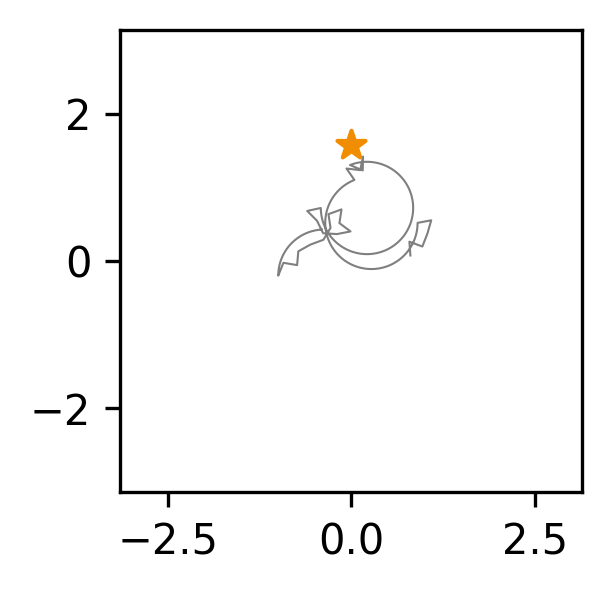

In [3]:
# Seed for reproducibility
# np.random.seed(111)

goal_loc = (-0.*np.pi, 0.5*np.pi)
direction = 'clockwise' 
# Run the function to generate movement data
results = simulate_honeycomb_movement(total_time=2, 
                                    dt=0.01, 
                                    move_prob=0.95, 
                                    velocity=6,
                                    goal_loc=goal_loc,
                                    direction=direction)

Animal_location_all, Head_direction_all, MV_direction_all, Dir2Goal_all, Animal_speed_all, rotation_phases, time_upsampled, Animal_Vel_all = results

Animal_location_all = Animal_location_all*np.pi-0.5*np.pi
Animal_speed_all = Animal_speed_all/1000

fig,ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
ax.plot(Animal_location_all[:,0],Animal_location_all[:,1], color = 'black', alpha = 0.5, linewidth = 0.5)
ax.scatter(goal_loc[0], goal_loc[1], color='#F18D00', marker='*', s=50, zorder=10)
ax.set_aspect('equal')
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)



### Simulate the model

In [4]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

v0 = 1.0*bm.pi/1000  #baseline speed
mbar_hd = 5. #HD adaptation strength 
mbar_pc = 10. #GC adaptation strength
noise_stre = 0.
Phase_Offset = 1.0
theta_hd_modulation = 0.4 # default 0.4; maximal 0.4
theta_gc_modulation = 0.5 # default 0.5; maximal 0.5,
Topdown_mod = 5.0 # strength of topdown modulation


#construct the model
#layer 1
HD_net = HD_cell_L1(num=100, 
                    noise_stre = noise_stre/6, #gc has muhc more neurons than hd, 10000 vs 100
                    tau=10., 
                    tau_v=100., 
                    k=1., 
                    mbar=mbar_hd, 
                    a=0.4, 
                    A=3., 
                    J0=4., 
                    z_min=-bm.pi, 
                    z_max=bm.pi, 
                    goal_a=0.4, 
                    goal_A=3.0, 
                    topdown=True)

#layer 2
PC_net = PC_cell_L2(noise_stre = noise_stre,
                    num=50,
                    tau = 10.,
                    tau_v = 100.,
                    mbar = mbar_pc,
                    a = 0.5,
                    A = 5, 
                    td_A = 5,
                    J0 = 10.0,
                    k = 1.0,
                    g = 1000,
                    x_min=-bm.pi,
                    x_max=bm.pi,    
                    num_hd = 100,
                    Phase_Offset = Phase_Offset)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Animal_speed, Dir2Goal): 
    
    A_modulation = (2+Animal_speed/v0)/5
    theta_modulation_stre_hd = theta_hd_modulation * Animal_speed / v0
    theta_modulation_stre_gc = theta_gc_modulation * Animal_speed / v0

    T_theta = 100 #100ms a cycle, i.e., 10 Hz a second
    #calculate TheataModulator at time step i for HD and GC
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta 
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = (1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)) * A_modulation
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod, Dir2Goal)
    HD_bumpcenter = HD_net.center #center of mass of internal direction
    HD_bumpactivity = HD_net.r 
    # print(HD_activity.shape)
        
    #update the grid cell network 
    PC_net.step_run(i, Animal_location, HD_bumpactivity, ThetaModulator_GC, Head_direction)
    
    #get results
    PC_bumpcenter = PC_net.center_bump
    PC_bumpactivity = PC_net.r
    return PC_bumpcenter, HD_bumpcenter, PC_bumpactivity, HD_bumpactivity, theta_phase, ThetaModulator_HD

time_steps = np.arange(len(Animal_location_all))
print('Running simulation...')

@bm.jit
def run(time, pos, hd, speed, d2g):
    return bm.for_loop(run_CoupleNet, (time, pos, hd, speed, d2g))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Animal_location_all), 50, 50))
hd_activity = np.empty((len(Animal_location_all), 100))
pc_bumpcenter = np.empty((len(Animal_location_all), 2))
hd_bumpcenter = np.empty((len(Animal_location_all), 1))
theta_phase = np.empty(len(Animal_location_all))
theta_rhythm = np.empty(len(Animal_location_all))

for i in range(0, len(Animal_location_all), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Animal_location_all)*100))
    results = run(time_steps[i:i+simulate_time], 
                    Animal_location_all[i:i+simulate_time], 
                    MV_direction_all[i:i+simulate_time],
                    Animal_speed_all[i:i+simulate_time],
                    Dir2Goal_all[i:i+simulate_time])
    
    pc_bumpcenter_i, hd_bumpcenter_i, pc_activity_i, hd_activity_i, theta_phase_i, theta_rhythm_i = results
    
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i).reshape((-1,50,50))
    hd_activity[i:i+simulate_time,:] = np.asarray(hd_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    hd_bumpcenter[i:i+simulate_time,:] = np.asarray(hd_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)

2025-06-25 17:43:17.169850: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running simulation...
Simulation progress: 0%


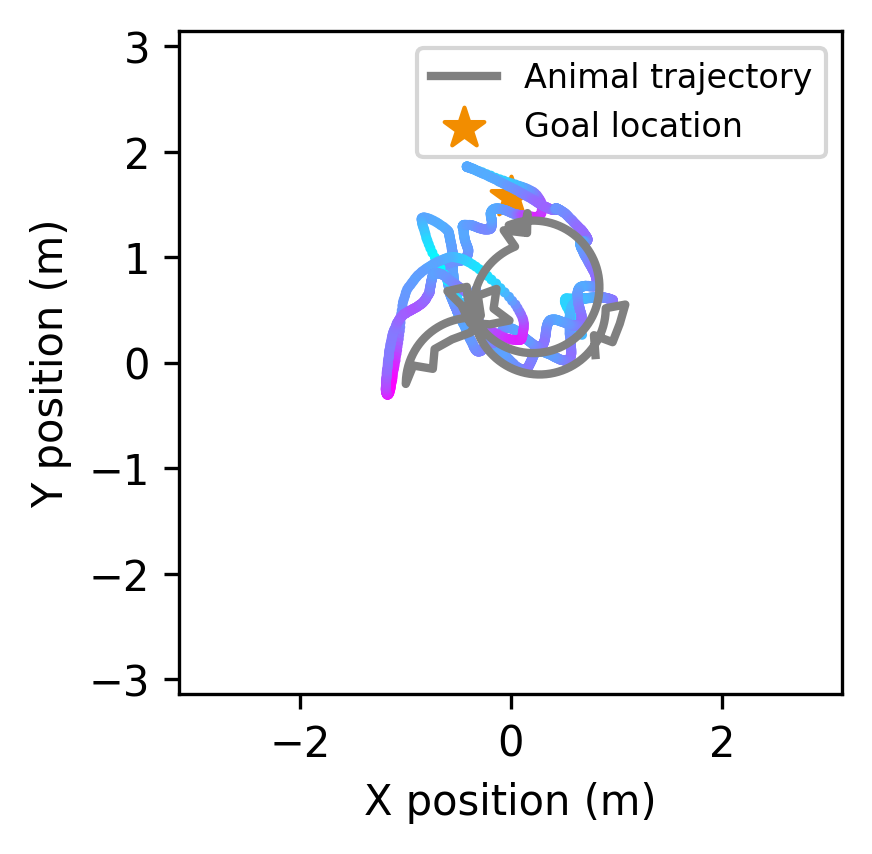

In [5]:
fig, ax  = plt.subplots(1, 1, figsize=(3,3), dpi=300)
num = 50
z_max = np.pi
time_steps = np.arange(len(Animal_location_all))
max_r_grid = np.max(pc_activity, axis=(1,2)) 

# Static plot for position and bump center in the second subplot (axs[1])
ax.plot(Animal_location_all[:, 0], Animal_location_all[:, 1], color='grey', linewidth=2, label='Animal trajectory')
ax.scatter(goal_loc[0], goal_loc[1], color='#F28D00', marker='*', s=100, label='Goal location')

sc = ax.scatter(
                pc_bumpcenter[:, 0],
                pc_bumpcenter[:, 1],
                c=max_r_grid,
                cmap="cool",
                s=2,
        )

ax.set_aspect('equal')
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)
ax.legend(fontsize=8)
ax.set_xlabel('X position (m)', fontsize=10)
ax.set_ylabel('Y position (m)', fontsize=10)

plt.tight_layout()


## Section 2: simulate a long spinning trajectory

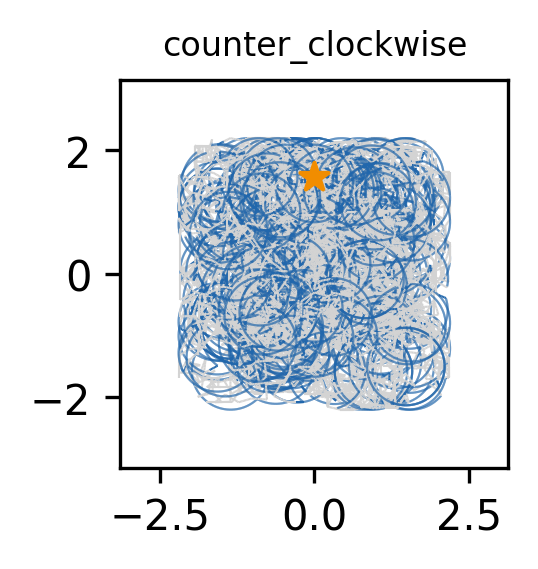

In [6]:
# Seed for reproducibility
# np.random.seed(111)
goal_loc = (-0.*np.pi, 0.5*np.pi)
# direction = 'clockwise' 
direction = 'counter_clockwise'
# Run the function to generate movement data
results = simulate_honeycomb_movement(total_time=300, 
                                    dt=0.01, 
                                    move_prob=0.95, 
                                    velocity=8,
                                    goal_loc=goal_loc,
                                    direction=direction)

Animal_location_all, Head_direction_all, MV_direction_all, Dir2Goal_all, Animal_speed_all, rotation_phases, time_upsampled, Animal_Vel_all = results

Animal_location_all = Animal_location_all*np.pi-0.5*np.pi
Animal_speed_all /= 1000

fig,ax = plt.subplots(1,1,figsize=(2,2), dpi=300)


# 1. XY Trajectory Plot (Upsampled)
segments = np.array([[Animal_location_all[i], Animal_location_all[i + 1]] for i in range(len(Animal_location_all) - 1)])
colors = ['#2167AC' if rotation_phases[i] else 'lightgrey' for i in range(len(Animal_location_all) - 1)] #28A25F
#colors = ['#28A25F' if rotation_phases[i] else 'lightgrey' for i in range(len(Position) - 1)] 
lc = LineCollection(segments, colors=colors, linewidths=0.5, alpha=1)
ax.add_collection(lc)
ax.set_aspect('equal')
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)


#add goal location
goal_loc = (-0.*np.pi, 0.5*np.pi)
ax.scatter(goal_loc[0], goal_loc[1], color='#F18D00', marker='*', s=50, zorder=10)


ax.set_title(direction, fontsize=8)

plt.tight_layout()



In [7]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

v0 = 1.0*bm.pi/1000  #baseline speed
mbar_hd = 5. #HD adaptation strength 
mbar_pc = 5. #GC adaptation strength
noise_stre = 0.
Phase_Offset = 1.0
theta_hd_modulation = 0.4 # default 0.4; maximal 0.4
theta_gc_modulation = 0.2 # default 0.5; maximal 0.5,
Topdown_mod = 5.0 # strength of topdown modulation


#construct the model
#layer 1
HD_net = HD_cell_L1(num=100, 
                    noise_stre = noise_stre/6, #gc has muhc more neurons than hd, 10000 vs 100
                    tau=10., 
                    tau_v=100., 
                    k=1., 
                    mbar=mbar_hd, 
                    a=0.4, 
                    A=3., 
                    J0=4., 
                    z_min=-bm.pi, 
                    z_max=bm.pi, 
                    goal_a=0.4, 
                    goal_A=3.0, 
                    topdown=True)

#layer 2
PC_net = PC_cell_L2(noise_stre = noise_stre,
                    num=50,
                    tau = 10.,
                    tau_v = 100.,
                    mbar = mbar_pc,
                    a = 0.5,
                    A = 5, 
                    td_A = 5,
                    J0 = 10.0,
                    k = 1.0,
                    g = 1000,
                    x_min=-bm.pi,
                    x_max=bm.pi,    
                    num_hd = 100,
                    Phase_Offset = Phase_Offset)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Animal_speed, Dir2Goal): 
    
    A_modulation = (2+Animal_speed/v0)/5
    theta_modulation_stre_hd = theta_hd_modulation * Animal_speed / v0
    theta_modulation_stre_gc = theta_gc_modulation * Animal_speed / v0

    T_theta = 100 #100ms a cycle, i.e., 10 Hz a second
    #calculate TheataModulator at time step i for HD and GC
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta 
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = (1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)) * A_modulation
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod, Dir2Goal)
    HD_bumpcenter = HD_net.center #center of mass of internal direction
    HD_bumpactivity = HD_net.r 
    # print(HD_activity.shape)
        
    #update the grid cell network 
    PC_net.step_run(i, Animal_location, HD_bumpactivity, ThetaModulator_GC, Head_direction)
    
    #get results
    PC_bumpcenter = PC_net.center_bump
    PC_bumpactivity = PC_net.r
    return PC_bumpcenter, HD_bumpcenter, PC_bumpactivity, HD_bumpactivity, theta_phase, ThetaModulator_HD

time_steps = np.arange(len(Animal_location_all))
print('Running simulation...')

@bm.jit
def run(time, pos, hd, speed, d2g):
    return bm.for_loop(run_CoupleNet, (time, pos, hd, speed, d2g))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Animal_location_all), 50, 50))
hd_activity = np.empty((len(Animal_location_all), 100))
pc_bumpcenter = np.empty((len(Animal_location_all), 2))
hd_bumpcenter = np.empty((len(Animal_location_all), 1))
theta_phase = np.empty(len(Animal_location_all))
theta_rhythm = np.empty(len(Animal_location_all))

for i in range(0, len(Animal_location_all), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Animal_location_all)*100))
    pc_bumpcenter_i, hd_bumpcenter_i, pc_activity_i, hd_activity_i, theta_phase_i, theta_rhythm_i = run(time_steps[i:i+simulate_time], 
                                                                                                        Animal_location_all[i:i+simulate_time], 
                                                                                                        MV_direction_all[i:i+simulate_time],
                                                                                                        Animal_speed_all[i:i+simulate_time],
                                                                                                        Dir2Goal_all[i:i+simulate_time])
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i).reshape((-1,50,50))
    hd_activity[i:i+simulate_time,:] = np.asarray(hd_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    hd_bumpcenter[i:i+simulate_time,:] = np.asarray(hd_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)

Running simulation...
Simulation progress: 0%
Simulation progress: 17%
Simulation progress: 33%
Simulation progress: 50%
Simulation progress: 67%
Simulation progress: 83%


In [8]:
# Compute relative angles in range [-π, π]
relative_angle = np.zeros(len(Head_direction_all))

for i in range(len(Head_direction_all)):
    # Unit vector of head direction
    vec1 = np.array([np.cos(Head_direction_all[i]), np.sin(Head_direction_all[i])])
    
    # Vector from current position to goal
    vec2 = goal_loc - Animal_location_all[i]  # (goal - current position)
    vec2 = vec2 / np.linalg.norm(vec2)  # Normalize vec2
    
    # Compute the signed angle using atan2
    relative_angle[i] = np.arctan2(vec2[1], vec2[0]) - np.arctan2(vec1[1], vec1[0])
    
    # Wrap angle to range [-π, π]
    relative_angle[i] = (relative_angle[i] + np.pi) % (2 * np.pi) - np.pi

(-0.5, 49.5, -0.5, 49.5)

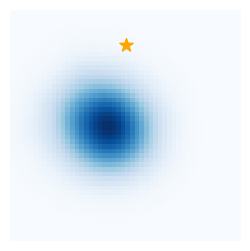

In [9]:
fig, ax = plt.subplots(1,1, figsize=(3,3))

cellindex = [24, 24]
num = 50

Position_norm = (Animal_location_all - Animal_location_all.min()-1e-5)/(Animal_location_all.max() - Animal_location_all.min())
dim = num
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)

ax.imshow(tuningMap, origin='lower', cmap='Blues')

#mark the goal location
goal_x = (goal_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*(dim-1)
goal_y = (goal_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*(dim-1)

ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

ax.set_aspect('equal')

ax.axis('off')

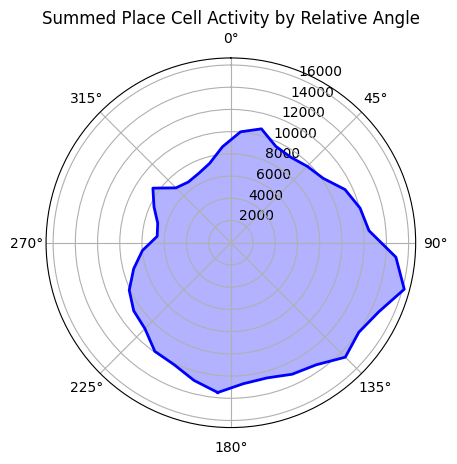

In [15]:
cellindex = [24, 24]


pc_activity_i=pc_activity[:, cellindex[0], cellindex[1]]

# Define bins for relative angles from -π to π
num_bins = 36
angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)  # 37 edges for 36 bins
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2  # Compute bin centers

# Initialize summed activity for each bin
binned_activity = np.zeros(num_bins)

# Assign each relative angle to a bin and sum corresponding activity
bin_indices = np.digitize(relative_angle, angle_bins) - 1  # -1 to convert to 0-based index

for i in range(len(relative_angle)):
    if 0 <= bin_indices[i] < num_bins:  # Ensure within valid bin range
        binned_activity[bin_indices[i]] += pc_activity_i[i]

# Convert bin centers to a polar coordinate system
theta = bin_centers

# Close the circle by repeating first value at the end
theta = np.append(theta, theta[0])

binned_activity = np.append(binned_activity, binned_activity[0])

# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, binned_activity, color='blue', linewidth=2)
ax.fill(theta, binned_activity, color='blue', alpha=0.3)  # Fill for better visibility

ax.set_title("Summed Place Cell Activity by Relative Angle")

#making 0 degree at the top
ax.set_theta_zero_location('N')
#and 90 degree on the right
ax.set_theta_direction(-1) 

plt.show()

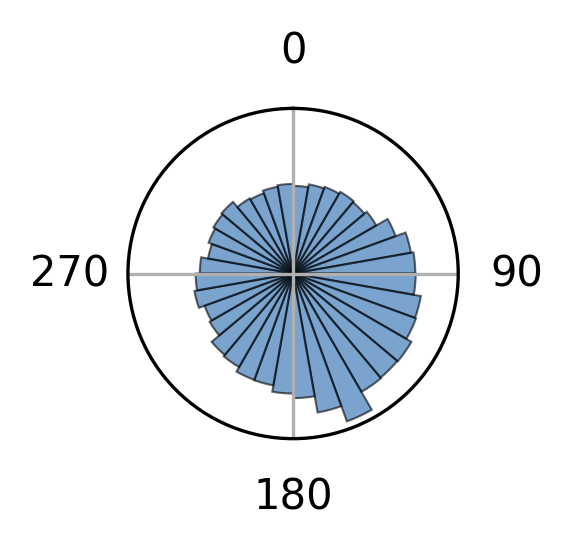

In [13]:
# Define the range of cell indices
start_idx = 15
end_idx = 35  # inclusive

# Define bins for relative angles from -π to π
num_bins = 36
angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

# Initialize accumulator for summed activity across all selected cells
total_binned_activity = np.zeros(num_bins)
num_cells = 0

# Loop through the specified submatrix of cells
for i in range(start_idx, end_idx + 1):
    for j in range(start_idx, end_idx + 1):
        pc_activity_ij = pc_activity[:, i, j]
        binned_activity = np.zeros(num_bins)
        bin_indices = np.digitize(relative_angle, angle_bins) - 1

        for k in range(len(relative_angle)):
            if 0 <= bin_indices[k] < num_bins:
                binned_activity[bin_indices[k]] += pc_activity_ij[k]

        total_binned_activity += binned_activity
        num_cells += 1

# Compute the average binned activity
average_binned_activity = total_binned_activity / num_cells

# Convert bin centers to polar coordinates
theta = np.append(bin_centers, bin_centers[0])
average_binned_activity = np.append(average_binned_activity, average_binned_activity[0])


# Create polar plot with bars instead of line
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(2, 2), dpi=300)

# Bar width based on bin size
bar_width = 2 * np.pi / num_bins

# Use only the first 36 values (drop the wrapped one)
bars = ax.bar(
    bin_centers,
    average_binned_activity[:-1],  # exclude the repeated value
    width=bar_width,
    bottom=0.0,
    color='#2167AC', #'#2167AC', #28A25F
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

# Polar aesthetics
ax.set_theta_zero_location('N')  # 0 at top
ax.set_theta_direction(-1)       # clockwise
# ax.set_title('Average Place Cell Activity by Angle', va='bottom')

#only show 0, 90, 180, 270
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])

#remove y ticks
ax.set_yticks([])

# plt.show()

plt.tight_layout()
if direction == 'clockwise':
    plt.savefig('./figures/average_activity_polar_CW.pdf', dpi=300)
elif direction == 'counter_clockwise':
    plt.savefig('./figures/average_activity_polar_CCW.pdf', dpi=300)
else:
    pass


## Check if place cells are consink cells, following the work did by Jake

15 15
15 19
15 23
15 27
15 31
15 35
19 15
19 19
19 23
19 27
19 31
19 35
23 15
23 19
23 23
23 27
23 31
23 35
27 15
27 19
27 23
27 27
27 31
27 35
31 15
31 19
31 23
31 27
31 31
31 35
35 15
35 19
35 23
35 27
35 31
35 35


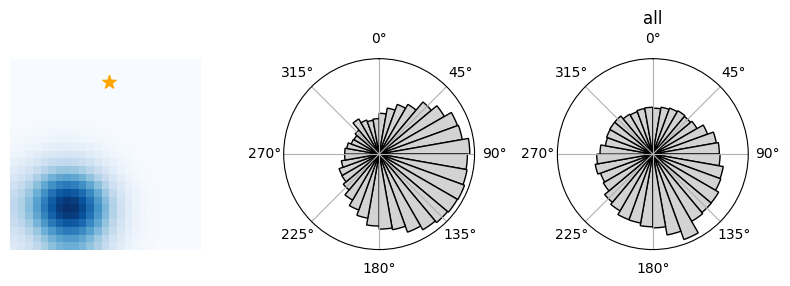

In [46]:
#Vel, Position, goal_loc, pc_activity
dt = 0.001

# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase

addfitline = True

fig = plt.figure(figsize=(8,3), dpi=100)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

cellindex = [20, 15]

ax = plt.subplot(gs[0])
#tuning map of a cell

Position_norm = (Animal_location_all - Animal_location_all.min() - 1e-5)/(Animal_location_all.max() - Animal_location_all.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)
ax.imshow(tuningMap, cmap='Blues', origin='lower')

#mark the goal location
goal_x = (goal_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim
goal_y = (goal_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim

ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

ax.axis('off')


####################################################################################################

#Phase against distance to goal

SpikePhase = []
RelativeDirection = []

r = pc_activity[:, cellindex[0], cellindex[1]] #ms to s

for i in range(len(Animal_location_all)):
    
    #get the vec pointing from Position to goal_loc
    vec = goal_loc - Animal_location_all[i]
    #get the angle between direction2goal and head direction
    # angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Animal_Vel_all[i, 1], Animal_Vel_all[i, 0])
    angle = np.arctan2(vec[1], vec[0]) - Head_direction_all[i]
    angle = np.degrees(angle) % 360
    
    #get the phase at current time step i
    phase_i = theta_phase[i]*np.pi*2
    
    spikes = np.random.poisson(r[i])
    if spikes > 0:
        RelativeDirection.append(angle)



####################################################################################################
#ConSink
ax = plt.subplot(gs[1], projection='polar')
#plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
ax.hist(np.radians(RelativeDirection), bins=36, color='lightgrey', edgecolor='black')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])
plt.tight_layout()


####################################################################################################
start_idx = 15
end_idx = 35  # inclusive
RelativeDirection_all = []

for ii in range(start_idx, end_idx + 1, 4):
    for jj in range(start_idx, end_idx + 1, 4):
        
        print(ii, jj)
        
        r = pc_activity[:, ii, jj] * 1 #ms to s

        for i in range(len(Animal_location_all)):
            
            #get the vec pointing from Position to goal_loc
            vec = goal_loc - Animal_location_all[i]
            #get the angle between vec and moving direction
            # angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Animal_Vel_all[i, 1], Animal_Vel_all[i, 0])
            angle = np.arctan2(vec[1], vec[0]) - Head_direction_all[i]
            angle = np.degrees(angle) % 360
            
            #get the phase at current time step i
            phase_i = theta_phase[i]*np.pi*2
            
            spikes = np.random.poisson(r[i])
            if spikes > 0:
                RelativeDirection_all.append(angle)
                
#ConSink
ax = plt.subplot(gs[2], projection='polar')
#plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
ax.hist(np.radians(RelativeDirection_all), bins=36, color='lightgrey', edgecolor='black')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_yticks([])
ax.set_title('all')

plt.tight_layout()




In [25]:
import numpy as np
import pycircstat.descriptive as cd
import pycircstat.tests as ct

def getSpike_RelativeDirection(cellindex, consink_loc, Animal_location, Head_direction):

    RelativeDirection = []

    r = pc_activity[:, cellindex[0], cellindex[1]]

    for i in range(len(Animal_location)):
        
        #get the vec pointing from Position to consink_loc
        vec = consink_loc - Animal_location[i]
        #get the angle between vec and moving direction
        angle = (np.arctan2(vec[1], vec[0]) - Head_direction[i] + np.pi) % (2 * np.pi) - np.pi
        angle = np.degrees(angle) % 360
        
        spikes = np.random.poisson(r[i])
        if spikes > 0:
            RelativeDirection.append(np.radians(angle))
    
    # Compute mean vector length (r)
    r = cd.resultant_vector_length(np.asarray(RelativeDirection))
    
    
    # # Perform Rayleigh test
    # pval, z = ct.rayleigh(RelativeDirection)
            
    return np.asarray(RelativeDirection), r


# cellindex = [15,25]
# goal_loc = (0.*np.pi, 0.5*np.pi)
# RelativeDirection, r = getSpike_RelativeDirection(cellindex, goal_loc, Animal_location_all, Head_direction_all)

cellindex = [24,24]

# Define candidate sink locations
consink_x = np.linspace(-0.5*np.pi, 0.5*np.pi, 20)
consink_y = np.linspace(-0.5*np.pi, 0.5*np.pi, 20)

# Track best result
best_r = -np.inf
best_sink = None
best_direction = None

for cx in consink_x:
    for cy in consink_y:
        consink_loc = [cx, cy]
        
        print(consink_loc)
        
        RelativeDirection, r = getSpike_RelativeDirection(cellindex, consink_loc, Animal_location_all, Head_direction_all)
        if r > best_r:
            best_r = r
            best_sink = consink_loc
            best_direction = RelativeDirection

print(f"Best consink location: {best_sink}")
print(f"Max mean vector length (r): {best_r:.3f}")

# ####################################################################################################
# #ConSink
# fig = plt.figure(figsize=(4, 4), dpi=150)
# ax = fig.add_subplot(1, 1, 1, projection='polar')  
# #plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
# ax.hist(RelativeDirection, bins=36, color='lightgrey', edgecolor='black')
# ax.set_theta_zero_location('N')
# ax.set_theta_direction(-1)
# ax.set_yticks([])
# plt.tight_layout()



[-1.5707963267948966, -1.5707963267948966]
[-1.5707963267948966, -1.4054493450270127]
[-1.5707963267948966, -1.2401023632591288]
[-1.5707963267948966, -1.074755381491245]
[-1.5707963267948966, -0.9094083997233612]
[-1.5707963267948966, -0.7440614179554773]
[-1.5707963267948966, -0.5787144361875936]
[-1.5707963267948966, -0.4133674544197097]
[-1.5707963267948966, -0.2480204726518258]
[-1.5707963267948966, -0.08267349088394194]
[-1.5707963267948966, 0.08267349088394194]
[-1.5707963267948966, 0.2480204726518258]
[-1.5707963267948966, 0.41336745441970946]
[-1.5707963267948966, 0.5787144361875933]
[-1.5707963267948966, 0.7440614179554772]
[-1.5707963267948966, 0.9094083997233611]
[-1.5707963267948966, 1.074755381491245]
[-1.5707963267948966, 1.2401023632591288]
[-1.5707963267948966, 1.4054493450270127]
[-1.5707963267948966, 1.5707963267948966]
[-1.4054493450270127, -1.5707963267948966]
[-1.4054493450270127, -1.4054493450270127]
[-1.4054493450270127, -1.2401023632591288]
[-1.4054493450270127

KeyboardInterrupt: 

In [27]:
import numpy as np
import pycircstat.descriptive as cd

def getSpike_RelativeDirection(consink_loc, Animal_location, Head_direction, spikes):
    """
    Computes the relative direction (in radians) between the head direction and the vector
    pointing from the current position to a candidate sink location, for timepoints where spikes occurred.

    Returns:
        RelativeDirection (ndarray): Vector of relative angles in radians.
        r (float): Mean vector length.
    """
    # Only retain timepoints where spikes occurred
    mask = spikes > 0
    if not np.any(mask):
        return np.array([]), 0.0  # No spikes -> return r=0

    pos = Animal_location[mask]
    hd = Head_direction[mask]

    # Vector from current position to consink
    vec = consink_loc - pos  # shape (N, 2)
    vec_angle = np.arctan2(vec[:, 1], vec[:, 0])  # angle to consink

    # Compute head-relative angle, wrap to [-π, π]
    angle_diff = (vec_angle - hd + np.pi) % (2 * np.pi) - np.pi

    # Mean vector length
    r = cd.resultant_vector_length(angle_diff)

    return angle_diff, r


# ---------------------- Parameters ----------------------

cellindex = [24, 24]  # example cell index
r = pc_activity[:, cellindex[0], cellindex[1]]  # firing rate for this cell
spikes = np.random.poisson(r)

# Sink location grid
consink_x = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)
consink_y = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)

best_r = -np.inf
best_sink = None
best_direction = None

# ---------------------- Grid search ----------------------

for cx in consink_x:
    for cy in consink_y:
        consink_loc = np.array([cx, cy])
        print(consink_loc)
        RelativeDirection, r_val = getSpike_RelativeDirection(
            consink_loc, Animal_location_all, Head_direction_all, spikes
        )
        if r_val > best_r:
            best_r = r_val
            best_sink = consink_loc
            best_direction = RelativeDirection

# ---------------------- Output ----------------------

print(f"Best consink location: {best_sink}")
print(f"Max mean vector length (r): {best_r:.3f}")



[-1.57079633 -1.57079633]
[-1.57079633 -1.40544935]
[-1.57079633 -1.24010236]
[-1.57079633 -1.07475538]
[-1.57079633 -0.9094084 ]
[-1.57079633 -0.74406142]
[-1.57079633 -0.57871444]
[-1.57079633 -0.41336745]
[-1.57079633 -0.24802047]
[-1.57079633 -0.08267349]
[-1.57079633  0.08267349]
[-1.57079633  0.24802047]
[-1.57079633  0.41336745]
[-1.57079633  0.57871444]
[-1.57079633  0.74406142]
[-1.57079633  0.9094084 ]
[-1.57079633  1.07475538]
[-1.57079633  1.24010236]
[-1.57079633  1.40544935]
[-1.57079633  1.57079633]
[-1.40544935 -1.57079633]
[-1.40544935 -1.40544935]
[-1.40544935 -1.24010236]
[-1.40544935 -1.07475538]
[-1.40544935 -0.9094084 ]
[-1.40544935 -0.74406142]
[-1.40544935 -0.57871444]
[-1.40544935 -0.41336745]
[-1.40544935 -0.24802047]
[-1.40544935 -0.08267349]
[-1.40544935  0.08267349]
[-1.40544935  0.24802047]
[-1.40544935  0.41336745]
[-1.40544935  0.57871444]
[-1.40544935  0.74406142]
[-1.40544935  0.9094084 ]
[-1.40544935  1.07475538]
[-1.40544935  1.24010236]
[-1.40544935

In [29]:
spikes.shape

(299991,)

In [30]:
r.shape

(299991,)